# Introducción a las prácticas de laboratorio de Deep Learning y sus Aplicaciones

## 2 - Otro ejemplo más complicado: el problema de las dos espirales

Es altamente no lineal. Aquí se va a ver en 2 dimensiones (se puede generalizar a más dimensiones, como ocurre con el problema del ExcluiveOR).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import sklearn
# Para acelerar los cálculos de scikit-learn (sklearn) en los procesadores Intel
# pip install scikit-learn-intelex
# y añadir en tus scripts
# from sklearnex import patch_sklearn
# patch_sklearn()

import tensorflow as tf
# import tensorflow.compat.v1 as tf   # para tensorflow-directml

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import History



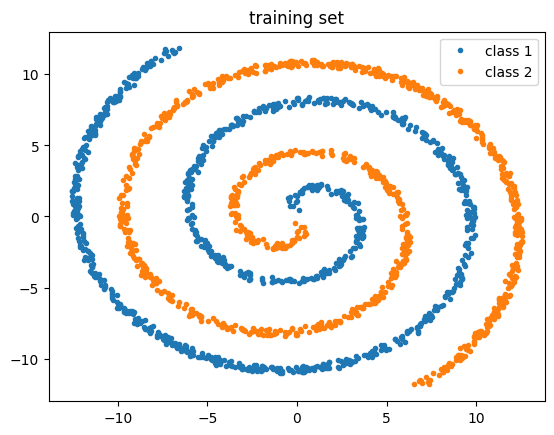

In [2]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)

# X son las coordenadas (x,y) de cada punto.
# y son los valores o clases


plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

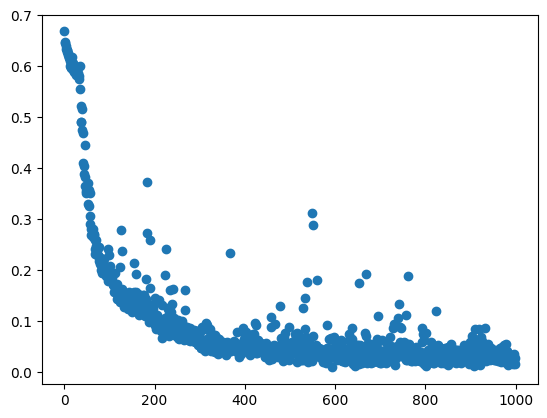

In [3]:
# Crear y entrenar el mlp

history = History ()

model = Sequential()
model.add(layers.Dense(8, input_dim=2, activation='tanh', name='Oculta1'))
model.add(layers.Dense(6, activation='tanh', name='Oculta2'))
model.add(layers.Dense(4, activation='tanh', name='Oculta3'))
model.add(layers.Dense(1, activation='sigmoid', name="Salida"))

opt = RMSprop (learning_rate=0.01, momentum=0.0, epsilon=1e-7)

model.compile(loss='binary_crossentropy', optimizer=opt)

model.fit(X, y, epochs=1000, batch_size=10, verbose=0, callbacks=[history])

epochs=history.epoch
loss=history.history['loss']

plt.scatter (epochs, loss)

1/1 [==============================] - 0s 32ms/step


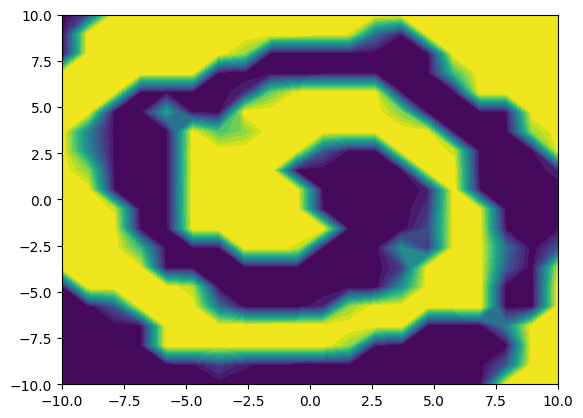

In [4]:
# Una representación gráfica algo espectacular...
Pasos=20
x0=np.linspace (-10.0, 10.0, Pasos)
y0=np.linspace (-10.0, 10.0, Pasos)

SalidaPrueba = np.empty (0)

for y_prueba in y0:
  for x_prueba in x0:
    EntradaPrueba=[x_prueba, y_prueba]
    z=model.predict ([[x_prueba, y_prueba]])
    SalidaPrueba=np.append (SalidaPrueba, z)


plt.contourf (x0, y0, SalidaPrueba.reshape (Pasos, Pasos), 20)

## Trabajo un poco más serio
Vamos a intentar estimar la capacidad de generalización de la red, probando el modelo con datos no vistos durante el entrenamiento.

In [5]:
# Dividir los datos en entrenamiento y prueba.

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split (X, y, test_size=0.1)

### Crear funciones útiles
Como hemos visto en el apartado anterior que somos capaces de reproducir las dos espirales con una red neuronal artificial, vamos a crear un par de funciones englobando ese código y así poder reutilizarlo varias veces con la posibilidad de cambiar parámetros en cada ocasión.

In [6]:
# Función que crea y entrena el mlp

def mi_mlp (npe1=8, npe2=8, epocas=1000, lr=0.001):
    # Fíjate en los valores por defecto de los parámetros
    history = History ()

    print ("Parámetros:",npe1, npe2, epocas, lr)
    
    model = Sequential()
    model.add(layers.Dense(npe1, input_dim=2, activation='tanh', name="Oculta1"))
    model.add(layers.Dense(npe2, activation='tanh', name="Oculta2"))
    model.add(layers.Dense(1, activation='sigmoid', name="Salida"))

    opt = RMSprop(learning_rate=0.01, momentum=0.0, epsilon=1e-7)
    
    model.compile(loss='binary_crossentropy', optimizer=opt)

    model.fit(X_train, Y_train, epochs=epocas, batch_size=10, verbose=0, callbacks=[history])

    #epochs=history.epoch
    #loss=history.history['loss']

    #plt.scatter (epochs, loss)
    #plt.show()
    return model

In [7]:
# Función que visualiza las espirales generadas por el modelo

def DibujaEspiral (modelo):
    model=modelo
    Pasos=20
    x0=np.linspace (-10.0, 10.0, Pasos)
    y0=np.linspace (-10.0, 10.0, Pasos)

    SalidaPrueba = np.empty (0)

    for y_prueba in y0:
      for x_prueba in x0:
        EntradaPrueba=[x_prueba, y_prueba]
        z=model.predict([[x_prueba, y_prueba]])
        SalidaPrueba=np.append (SalidaPrueba, z)


    plt.contourf (x0, y0, SalidaPrueba.reshape (Pasos, Pasos), 20)
    plt.show()

Parámetros: 8 8 1000 0.001
1/1 [==============================] - 0s 60ms/step


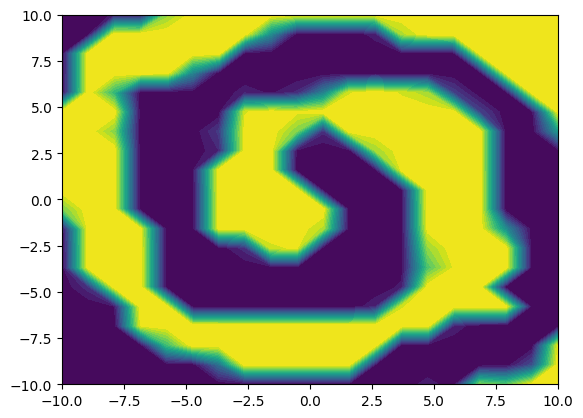

In [8]:
modelo=mi_mlp ()
DibujaEspiral(modelo)

Calculemos el error que se comete en el conjunto de prueba.

In [9]:
# ¡OJO! Este primer cálculo usa el error cuadrático medio.
z=model.predict (X_test)
e=z-Y_test.reshape ((200,1))
print ((e**2).mean ())

7/7 [==============================] - 0s 6ms/step
0.03202552343384832


In [10]:
# Pero lo que deberíamos ver es el número de puntos correctamente/erróneamente clasificados
# Para ello hay que binarizar la salida z:

eabs=abs (e)
fallos=0
for v in eabs:
    if v >= 0.5:
        fallos=fallos + 1

print (fallos)

7


### Aleatoriedad y Reproductibilidad de los experimentos
El resultado del algoritmo de aprendizaje depende de cómo inicialicemos los pesos.
Hay que repetir MUCHAS veces los experimentos y hacer estadísticas.
Por sí solo, Keras y Tensorflow ya incorporan un mecanismo de inicialización aleatoria de los pesos, cuya semilla se ajusta automáticamente.
Solo tienes que repetir el enrenamiento con los mismos datos y obtienes resultados diferentes.
Si quieres poder tener reproductivilidad en los experimentos, usa el método set_seed (X), que fuerza a usar la semilla que especifiques.

In [11]:
# Vamos a repetir el experimento (entrenar-probar) cinco veces.
# Pero para que sea más rápido, vamos cambiar los parámetros.

for vez in [1,2,3]:
    modelo=mi_mlp (epocas=10)
    z=modelo.predict (X_test)
    e=z-Y_test.reshape ((200,1))
    print (vez, (e**2).mean ())

Parámetros: 8 8 10 0.001
7/7 [==============================] - 0s 2ms/step
1 0.21430462871804923
Parámetros: 8 8 10 0.001
7/7 [==============================] - 0s 2ms/step
2 0.20127489271997362
Parámetros: 8 8 10 0.001
7/7 [==============================] - 0s 2ms/step
3 0.2188589516948852


In [12]:
# Ahora controlamos la aleatoriedad

import tensorflow

from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed # Ya no es necesario
for vez in [1,2,3,4,5]:
    tensorflow.random.set_seed(2)
    modelo=mi_mlp (epocas=10)
    z=modelo.predict (X_test)
    e=z-Y_test.reshape ((200,1))
    print (vez, (e**2).mean ())



Parámetros: 8 8 10 0.001
7/7 [==============================] - 0s 2ms/step
1 0.22091912464714228
Parámetros: 8 8 10 0.001
7/7 [==============================] - 0s 2ms/step
2 0.22588063214139475
Parámetros: 8 8 10 0.001
7/7 [==============================] - 0s 2ms/step
3 0.21693067825861548
Parámetros: 8 8 10 0.001
7/7 [==============================] - 0s 2ms/step
4 0.21964982953151924
Parámetros: 8 8 10 0.001
7/7 [==============================] - 0s 5ms/step
5 0.22016501871400898


### Optimización de hiperparámetros
Como habrás observaddo, al declarar la función mi_mlp hemos incluido la posibilidad de variar algunos de los hiperparámetros pasando el nuevo valor como argumento.


Busqemos alguna combinación que mejore los resultados. Para ello símplemente vamos a hacer un barrido y calcular el número puntos erróneamente asignados. 

In [14]:
dfResultados=pd.DataFrame (columns=["npe1", "npe2", "lcoef", "Fallos"])

for capa1 in [2, 4, 8, 16]:
    for capa2 in [2, 3, 4, 5]:
        for lcoef in [0.01, 0.001, 0.0001]:
            modelo=mi_mlp(npe1=capa1, npe2=capa2, lr=lcoef)
            z=modelo.predict (X_test)
            e=z-Y_test.reshape ((200,1))
            eabs=abs (e)
            fallos=0
            for v in eabs:
                if v >= 0.5:
                    fallos=fallos + 1

            dfResultados=dfResultados.append ({'npe1':capa1, 'npe2':capa2, 'lcoef':lcoef, 'Fallos':fallos}, ignore_index=True)
            
dfResultados

Parámetros: 2 2 1000 0.01
7/7 [==============================] - 0s 2ms/step


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# Esta celda está comentada porque no queremos perder el contenido del fichero que hemos creado hace un rato.

# dfResultados.to_csv ("Resultados_2Espirales.csv")

In [ ]:

dfResultados=pd.read_csv ("Resultados_2Espirales.csv")

In [ ]:
dfResultados

In [ ]:
dfResultados=dfResultados.pivot(index=["npe1", "lcoef"],columns="npe2",values="Fallos")
dfResultados.style.highlight_min ()